# HW2: Softmax Regression

(Cập nhật lần cuối: 02/03/2024)

Họ tên: Lê Thanh Thái Quảng

MSSV: 21120123

---

## Kiểm tra môi trường code

In [1]:
import sys
sys.executable

'/home/thaiquang03/miniconda3/envs/anaconda/bin/python'

Bạn nên thấy kết quả in ra là đường dẫn đến file chạy python của môi trường "ml-env" mà mình đã hướng dẫn bạn cài đặt ở HW0.

## Nắm bài toán cần giải quyết của bài tập này

Cho dữ liệu quan sát được (dữ liệu huấn luyện): 
$$\{(\textbf{x}^{(1)}, y^{(1)}), ..., (\textbf{x}^{(N_{train})}, y^{(N_{train})})\}$$

Trong đó:

- $\textbf{x}^{(n)} \in \mathbb{R}^{784}$ là véc-tơ đầu vào chứa các giá trị pixel của một ảnh xám $28\times28$, ảnh này là ảnh một chữ số viết tay nào đó (véc-tơ $784$ chiều được tạo từ ảnh xám $28\times28$ bằng cách nối các dòng của ảnh xám lại với nhau)
- $y^{(n)} \in \{0, 1, ..., 9\}$ là đầu ra tương ứng, cho biết đây là chữ số nào

Nhiệm vụ ở đây là tìm ra một (cách tiền xử lý và) mô hình (trong bài này: mô hình Softmax Regression) từ dữ liệu này sao cho (cách tiền xử lý và) mô hình này có thể nhận đầu vào là một ảnh-chữ-số-viết-tay *mới* (là một véc-tơ $\in \mathbb{R}^{784}$) và dự đoán đầu ra tương ứng (chữ số nào trong $\{0, 1, 2, ..., 9\}$) một cách *chính xác*.

## Import các thư viện cần thiết

In [2]:
import numpy as np
import os
import pickle
import gzip
import matplotlib.pyplot as plt
plt.style.use('ggplot') # Để hình vẽ đẹp hơn một xíu ...

Lưu ý: khi tính toán với mảng Numpy, bạn nên dùng các toán-tử/hàm/phương-thức mà Numpy đã cung cấp sẵn. Các toán-tử/hàm/phương-thức này làm trên nguyên mảng và ở bên dưới đã được tối ưu hóa; do đó, code sẽ ngắn gọn và chạy nhanh. Nếu bạn dùng vòng lặp for và làm với từng phần tử của mảng Numpy thì code sẽ dài và chạy chậm $\to$ bạn sẽ bị trừ điểm.

## Đọc dữ liệu

Bộ dữ liệu mà ta sẽ dùng trong bài này là MNIST - bộ dữ liệu chữ số viết tay "nổi tiếng" trong cộng đồng làm Machine Learning. [Bộ MNIST gốc](http://yann.lecun.com/exdb/mnist/) gồm có: dữ liệu huấn luyện (60000 ảnh) và dữ liệu kiểm tra (10000 ảnh). Bộ MNIST mà ta sẽ dùng trong bài này (file "mnist.pkl.gz") gồm có: dữ liệu huấn luyện (50000 ảnh), dữ liệu validation (10000 ảnh), và dữ liệu kiểm tra (10000 ảnh); dữ liệu huấn luyện và validation ở đây được tạo ra bằng cách tách ngẫu nhiên dữ luyện huấn luyện gốc ra thành 2 phần theo tỉ lệ 5:1. 

Về mặt ý nghĩa thì dữ liệu validation và dữ liệu kiểm tra đều là dữ liệu mới ngoài dữ liệu huấn luyện. Dữ liệu validation giống như đề thi thử, có thể được thi một vài lần; còn dữ liệu kiểm tra giống như đề thi thật, để đảm bảo kết quả được khách quan thì chỉ được thi một lần duy nhất! Khi làm Machine Learning, ta thường muốn thử một số cách tiền xử lý + mô hình để chọn ra cách tiền xử lý + mô hình tốt nhất. Với mỗi cách tiền xử lý + mô hình, ta sẽ huấn luyện trên dữ liệu huấn luyện và đo độ lỗi dự đoán trên dữ liệu validation; cuối cùng ta sẽ chọn cách tiền xử lý + mô hình mà có độ lỗi dự đoán thấp nhất trên dữ liệu validation (ta không chọn dựa vào độ lỗi dự đoán trên dữ liệu huấn luyện vì có thể xảy ra trường hợp "học vẹt": cách tiền xử lý + mô hình có độ lỗi rất thấp trên dữ liệu huấn luyện nhưng lại có độ lỗi cao với dữ liệu mới ngoài dữ liệu huấn luyện). Khi đã chọn xong cách tiền xử lý + mô hình rồi thì ta sẽ đo một lần duy nhất độ lỗi dự đoán trên dữ liệu kiểm tra để có một ước lượng khách quan về độ lỗi thật sự! Nếu bạn nhìn vào độ lỗi dự đoán trên dữ liệu kiểm tra và quay lại điều chỉnh cách tiền xử lý + mô hình thì kết quả trên dữ liệu kiểm tra sẽ không còn sự khách quan nữa!

Đoạn code dưới đây sẽ đọc dữ liệu từ file "mnist.pkl.gz" và lưu kết quả vào 6 mảng:

- `train_X`, `train_y`
- `val_X`, `val_y`
- `test_X`, `test_y`

In [3]:
def read_mnist(mnist_file):
    if os.path.isfile(mnist_file) == False:
        mnist_file = os.path.join(os.path.expanduser('~'), 'data', 'mnist.pkl.gz')
    
    f = gzip.open(mnist_file, 'rb')
    train_data, val_data, test_data = pickle.load(f, encoding='latin1')
    f.close()
    
    train_X, train_Y = train_data
    val_X, val_Y = val_data
    test_X, test_Y = test_data    
    
    return train_X, train_Y, val_X, val_Y, test_X, test_Y

# Bạn cần đặt file "mnist.pkl.gz" vào cùng thư mục với file notebook này,
# hoặc bạn cũng có thể đặt ở thư mục tương ứng với câu lệnh này:
# os.path.join(os.path.expanduser('~'), 'data')
train_X, train_y, val_X, val_y, test_X, test_y = read_mnist('Data/mnist.pkl.gz')
print(f'Shape of train_X: {train_X.shape}, shape of train_y: {train_y.shape}')
print(f'Shape of val_X:   {val_X.shape}, shape of val_y:   {val_y.shape}')
print(f'Shape of test_X:  {test_X.shape}, shape of test_y:  {test_y.shape}')

Shape of train_X: (50000, 784), shape of train_y: (50000,)
Shape of val_X:   (10000, 784), shape of val_y:   (10000,)
Shape of test_X:  (10000, 784), shape of test_y:  (10000,)


## Khám phá dữ liệu huấn luyện

Đầu tiên, ta hãy xem thử min và max của `train_X`.

In [4]:
print(f'Min of train_X: {train_X.min()}, max of train_X: {train_X.max()}')

Min of train_X: 0.0, max of train_X: 0.99609375


Với ảnh xám thì giá trị của mỗi pixel thường sẽ nằm trong đoạn [0, 255] (với 0 là màu đen và 255 là màu trắng), hoặc đôi khi được chuẩn hóa về đoạn [0, 1] (với 0 là màu đen và 1 là màu trắng). Ở đây có vẻ giá trị pixel của ảnh xám của ta nằm trong đoạn [0, 1].

Tiếp theo, ta hãy thử xem mặt mũi của vài ảnh trong `train_X`.

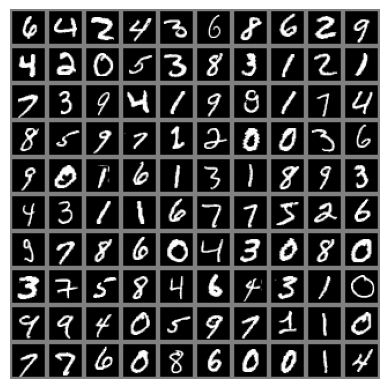

In [5]:
# Bạn có thể chạy cell này nhiều lần để xem các ảnh ngẫu nhiên khác nhau
n_rimages = 10; n_cimages = 10 
padding = 2 
canvas = 0.5 * np.ones((n_rimages * (28 + 2 * padding), n_cimages * (28 + 2 * padding)))
rand_idxs = np.random.permutation(np.arange(len(train_X))[:n_rimages * n_cimages])
for r in range(n_rimages):
    for c in range(n_cimages):
        i = r * n_cimages + c
        image = train_X[rand_idxs[i]].reshape(28, 28)
        temp1 = r * (28 + 2 * padding) + padding 
        temp2 = c * (28 + 2 * padding) + padding 
        canvas[temp1:temp1 + 28, temp2:temp2 + 28] = image
plt.imshow(canvas, cmap='gray', vmin=0, vmax=1)
plt.grid(None); plt.axis('off');

Tiếp theo, ta hãy xem các giá trị có thể có của `train_y` và số lượng của mỗi giá trị này.

In [6]:
values, counts = np.unique(train_y, return_counts=True)
for value, count in zip(values, counts):
    print(f'Value: {value}, count: {count}')

Value: 0, count: 4932
Value: 1, count: 5678
Value: 2, count: 4968
Value: 3, count: 5101
Value: 4, count: 4859
Value: 5, count: 4506
Value: 6, count: 4951
Value: 7, count: 5175
Value: 8, count: 4842
Value: 9, count: 4988


Như vậy là `train_y` có 10 giá trị có thể có ứng với 10 chữ số từ 0 đến 9. Và số lượng ảnh của mỗi chữ số cũng khá tương đương nhau. Tốt ...

## Tiền xử lý dữ liệu huấn luyện

Tương tự như mô hình Linear Regression ở HW1, với mô hình Softmax Regression trong bài này thì đầu tiên ta cũng sẽ thêm cột toàn 1 vào đầu `train_X`; bằng cách này, những tính toán về sau sẽ được thuận tiện hơn.

In [7]:
def add_ones(X):
    return np.hstack((np.ones((len(X), 1)), X))

# Gọi hàm add_ones để tiền xử lý train_X
train_Z = add_ones(train_X)
train_Z.shape

(50000, 785)

## Tìm mô hình Softmax Regression từ dữ liệu huấn luyện

Ta sẽ tìm bộ trọng số của mô hình Softmax Regression bằng cách cực tiểu hóa độ lỗi cross-entropy trên dữ liệu huấn luyện. Bạn có thể xem công thức tính độ lỗi cross-entropy ở trang 6 của slide "HW2-Slide.pdf" mà mình đính kèm. Ở đây, ta không thể giải ra trực tiếp bộ trọng số như ở mô hình Linear Regression, mà cần phải dùng một thuật toán cực tiểu hóa mà ban đầu sẽ khởi tạo đại bộ trọng số, rồi sẽ thực hiện nhiều vòng lặp, ở mỗi vòng lặp sẽ cập nhật bộ trọng số một ít để làm giảm độ lỗi trên dữ liệu huấn luyện. Trong bài này, ta sẽ cài đặt một thuật toán cực tiểu hóa đơn giản là Gradient Descent. Bạn có thể xem các bước của thuật toán Gradient Descent để tìm bộ trọng số của Softmax Regression ở trang 8-11 của slide "HW2-Slide.pdf". Theo đó thì ở mỗi vòng lặp, để tính gradient thì trước tiên ta sẽ cần tính các véc-tơ đầu ra của mô hình Softmax Regression ứng với các véc-tơ đầu vào của dữ liệu huấn luyện và bộ trọng số hiện tại.

Nhiệm vụ 1 của bạn (2đ): viết hàm `compute_smreg_output` để tính các véc-tơ đầu ra (hoặc các đầu ra) của mô hình Softmax Regression; ta sẽ dùng hàm này trong quá trình huấn luyện mô hình Softmax Regression (như đã nói ở trên) cũng như sau khi huấn huyện để dự đoán với các véc-tơ đầu vào mới. 

Hàm `compute_smreg_output` có các tham số đầu vào:
- `W`: mảng chứa các trọng số của mô hình Softmax Regression, mảng này có shape là `(d+1, K)` với `d` là số lượng phần tử của véc-tơ đầu vào (khi chưa thêm 1 ở đầu) và `K` là số lượng lớp; với dữ liệu cụ thể của ta thì `d` bằng 784 và `K` bằng 10  
- `X`: mảng chứa các véc-tơ đầu vào cần dự đoán, mảng này có shape là `(N, d+1)` với `N` là số lượng các véc-tơ đầu vào
- `return_prob`: nếu cờ này bằng `True` thì với mỗi véc-tơ đầu vào, ta sẽ trả về một véc-tơ đầu ra cho biết xác xuất của các lớp; nếu cờ này bằng `False` thì với mỗi véc-tơ đầu vào, ta sẽ trả về một giá trị đầu ra cho biết lớp mà có xác suất lớn nhất

Hàm `compute_smreg_output` sẽ trả về mảng chứa các véc-tơ đầu ra (hoặc các đầu ra) tương ứng với các véc-tơ đầu vào; nếu `return_prop` bằng True thì mảng trả về sẽ có shape `(N, K)`, còn nếu `return_prop` bằng `False` thì sẽ có shape `(N,)`.

In [8]:
def compute_smreg_output(W, X, return_prob=True):
    # YOUR CODE HERE
    # Tính ma trận score
    Z = np.dot(X, W)
    # Chuyển Score sáng Probability
    P = np.exp(Z) / np.exp(Z).sum(axis=1, keepdims=True)
    if not return_prob:
        return np.argmax(P, axis=1)
    return P

In [9]:
# TEST
# Tạo một mảng X với 4 dòng ứng với 4 véc-tơ đầu vào (đã thêm 1 ở đầu)
X = np.array([[1.0, 0.9], 
              [1.0, 0.5], 
              [1.0, 0.4],
              [1.0, 0.1]])
# Tạo một mảng W gồm có 3 cột ứng với bộ trọng số của 3 lớp
W = np.array([[ 0.3 ,  0.2 ,  0.5 ],
              [-0.1 , -0.2 , -0.35]])
# Kiểm tra hàm compute_smreg_output của bạn!
predicted_Y = compute_smreg_output(W, X)
assert predicted_Y.shape == (4, 3)
assert str(predicted_Y[0][0].round(4)) == '0.3569'
assert str(predicted_Y[1][0].round(4)) == '0.3403'
assert str(predicted_Y[2][0].round(4)) == '0.3362'
assert str(predicted_Y[3][0].round(4)) == '0.3239'
predicted_y = compute_smreg_output(W, X, return_prob=False)
assert predicted_y.shape == (4,)
assert list(predicted_y) == [0, 2, 2, 2]

Sau khi đã xong nhiệm vụ 1 thì bây giờ là nhiệm vụ 2 và cũng là nhiệm vụ chính của bạn (4đ): viết hàm `train_smreg` (trong hàm này thì bạn có thể dùng hàm `compute_smreg_output` mà bạn đã viết ở nhiệm vụ 1).

Hàm `train_smreg` có các tham số đầu vào:
- `X`: mảng chứa các véc-tơ đầu vào (đã được thêm 1 ở đầu) của dữ liệu huấn luyện, mảng này có shape là `(N, d+1)` với `N` là số lượng véc-tơ đầu vào của dữ liệu huấn luyện và `d` là số lượng phần tử của mỗi véc-tơ đầu vào (khi chưa thêm 1 ở đầu)
- `y`: mảng chứa các đầu ra tương ứng với các véc-tơ đầu vào của dữ liệu huấn luyện, mảng này có shape là `(N,)`
- `lr`: số thực > 0 cho biết hệ số học (learning rate) của thuật toán Gradient Descent
- `max_epoch`: số nguyên > 0 cho biết số vòng lặp tối đa của thuật toán Gradient Descent (ví dụ, nếu `max_epoch` bằng 10 thì ta sẽ chạy Gradient Descent với 10 vòng lặp)
- `initial_W`: mảng chứa các trọng số khởi tạo của mô hình Softmax Regression (ta sẽ chạy Gradient Descent từ các trọng số khởi tạo này), mảng này có shape là `(d+1, K)` với `K` là số lượng các lớp (với dữ liệu cụ thể của ta thì `K` bằng 10); nếu `initial_W` bằng `None` thì trong hàm `train_smreg` ta sẽ khởi tạo các trọng số của mô hình Softmax Regression với giá trị là 0 (với mô hình Softmax Regression thì ta khởi tạo như thế nào cũng được, ở đây ta thống nhất là khởi tạo với giá trị là 0 để thầy và trò sẽ ra cùng kết quả)

Hàm `train_smreg` trả về:
- Mảng chứa các trọng số tìm được của mô hình Softmax Regression, mảng này có shape là `(d+1, K)`
- List chứa độ lỗi cross-entropy trên dữ liệu huấn luyện sau mỗi vòng lặp, list này gồm có `max_epoch` phần tử. Bạn xem công thức tính độ lỗi cross-entropy trên dữ liệu huấn luyện ở trang 6 của slide "HW2-Slide.pdf"

Trong hàm `train_smreg` thì bước khó nhất là bước tính gradient. Bạn có thể xem công thức tính gradient ở trang 10 của slide "HW2-Slide.pdf". Cái khó và cũng là cái hay ở đây là từ công thức này, ta phải suy nghĩ ra cách code để tính gradient bằng các toán-tử/hàm/phương-thức của Numpy mà không dùng vòng lặp for! Vì nếu dùng vòng lặp thì code sẽ dài và chạy chậm. Mình sẽ giúp đỡ bạn một xíu bằng cách đưa ra một ví dụ cụ thể và bạn có thể dùng kiểm tra xem code tính gradient của bạn có đúng hay không trước khi đưa code này vào hàm `train_smreg`.

In [10]:
# Giả sử ta có mảng X với 4 dòng ứng với 4 véc-tơ đầu vào (đã thêm 1 ở đầu)
X = np.array([[1.0, 0.9], 
              [1.0, 0.5], 
              [1.0, 0.4],
              [1.0, 0.1]])
# Và đây là mảng Y (viết hoa) với:
# - 4 dòng ứng với 4 véc-tơ đầu ra dạng one-hot (ứng với 4 véc-tơ đầu vào của mảng X)
# - 3 cột ứng với 3 lớp
Y = np.array([[1, 0, 0], 
              [0, 1, 0], 
              [0, 0, 1], 
              [1, 0, 0]])
# Và đây là mảng predicted_Y với 4 dòng ứng với 4 véc-tơ đầu ra dự đoán (véc-tơ 
# chứa xác suất của các lớp) của mô hình Softmax Regression với bộ trọng số hiện tại
# (4 véc-tơ đầu ra dự đoán này ứng với 4 véc-tơ đầu vào của mảng X)
predicted_Y = np.array([[0.3569, 0.2951, 0.348 ],
                        [0.3403, 0.2929, 0.3668],
                        [0.3362, 0.2923, 0.3715],
                        [0.3239, 0.2902, 0.3859]])

# Tính gradient từ X, Y, và predicted_Y (chỉ cần 1 dòng code ;-) )
# grad = np.dot(X.T, (predicted_Y - Y)) / X.shape[0]
# print(grad)

# Nếu bạn tính gradient đúng thì kết quả in ra của mảng grad sẽ là:
# [[-0.160675   0.042625   0.11805  ]
#  [-0.0854425  0.014495   0.0709475]]

In [11]:
# Ngoài hàm compute_smreg_output, nếu muốn thì bạn có thể viết thêm các hàm phụ 
# trợ khác cho hàm train_smreg
# YOUR CODE HERE (OPTION)
def onehot(X):
    unique = np.unique(X)
    nrows = X.shape[0]
    ncols = len(unique)
    onehot_matrix = np.zeros((nrows, ncols))      
    onehot_matrix[np.arange(X.shape[0]), X] = 1

    return onehot_matrix

def compute_grad(W, X, y):
    y_predict = compute_smreg_output(W, X, return_prob=True)
    return(np.dot(X.T, (y_predict - onehot(y))) / X.shape[0])

def compute_cross_entropy_error(W, X, y):
    y_predict = compute_smreg_output(W, X, return_prob=True)
    cross_entropy_error = np.mean(-np.log(y_predict)[np.arange(len(y)), y])
    return cross_entropy_error

def train_smreg(X, y, lr, max_epoch, initial_W=None):
    # YOUR CODE HERE
    if initial_W is None:
        W = np.zeros((X.shape[1], len(np.unique(y))))
    else:
        W = initial_W
    
    cee_set = []   
    for t in range(0, max_epoch):
        grad = compute_grad(W, X, y)
        W = W - lr * grad
        cee = compute_cross_entropy_error(W, X, y)
        cee_set.append(cee)
        
    return W, cee_set

In [12]:
# TEST
W, train_ces = train_smreg(train_Z, train_y, lr=0.3, max_epoch=3)
assert W.shape == (785, 10)
assert str(W[0, 0].round(4)) == '-0.011'
assert len(train_ces) == 3
assert str(np.round(train_ces[0], 4)) == '2.0074'
assert str(np.round(train_ces[1], 4)) == '1.7753'
assert str(np.round(train_ces[2], 4)) == '1.5914'
W, train_ces = train_smreg(train_Z, train_y, lr=0.3, max_epoch=3, initial_W=W)
assert W.shape == (785, 10)
assert str(W[0, 0].round(4)) == '-0.0215'
assert len(train_ces) == 3
assert str(np.round(train_ces[0], 4)) == '1.4458'
assert str(np.round(train_ces[1], 4)) == '1.3295'
assert str(np.round(train_ces[2], 4)) == '1.2354'

Ở trên ta chỉ thử hàm `train_smreg` với `max_epoch` nhỏ (3) để có thể nhanh chóng kiểm tra tính đúng đắn của hàm `train_smreg`. Bây giờ mới là làm thật. Ta sẽ gọi `train_smreg` với `max_epoch` lớn. Tuy nhiên, ta sẽ cần chọn ra giá trị `lr` (learning rate) phù hợp để việc cực tiểu hóa của thuật toán Gradient Descent diễn ra một cách tốt đẹp. Để đỡ tốn thời gian, ta sẽ chia ra làm 2 giai đoạn. Ở giai đoạn đầu, ta sẽ gọi hàm `train_smreg` với `max_epoch` vừa vừa (100) và thử với các giá trị `lr`khác nhau (0.03, 0.3, 3). Sau khi quan sát kết quả, ta sẽ chọn ra giá trị `lr` phù hợp nhất, rồi qua giai đoạn 2: gọi tiếp hàm `train_smreg` với giá trị `lr` này và bộ trọng số tìm được trước đó và `max_epoch` lớn (400). Ta sẽ gọi bộ trọng số tìm được sau cùng là `W_1` (vì lúc sau ta sẽ thử một cách tiền xử lý + mô hình Softmax Regression khác, và ta sẽ gọi bộ trọng số tìm được là `W_2`).

Đầu tiên là giai đoạn 1.

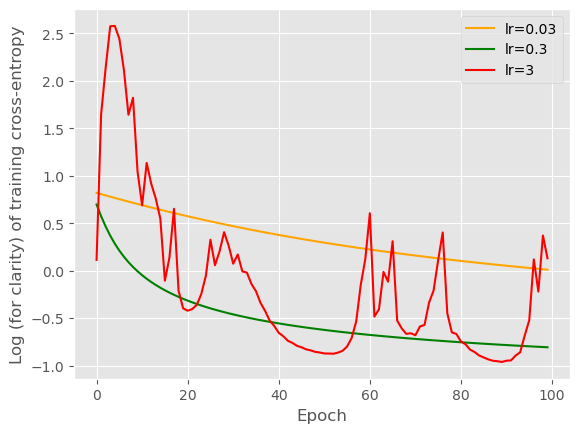

In [13]:
W_1a, train_ces_1a = train_smreg(train_Z, train_y, lr=0.03, max_epoch=100)
W_1b, train_ces_1b = train_smreg(train_Z, train_y, lr=0.3, max_epoch=100)
W_1c, train_ces_1c = train_smreg(train_Z, train_y, lr=3, max_epoch=100)

plt.plot(np.log(train_ces_1a), label='lr=0.03', color='orange')
plt.plot(np.log(train_ces_1b), label='lr=0.3', color='green')
plt.plot(np.log(train_ces_1c), label='lr=3', color='red')
plt.xlabel('Epoch')
plt.ylabel('Log (for clarity) of training cross-entropy')
plt.legend();

Nhiệm vụ của bạn (1đ): quan sát kết quả và giải thích tại sao kết quả lại như vậy (nếu bạn không biết tại sao thì cứ nói là không biết tại sao).

YOUR ANSWER HERE

Ta có: W = W - lr * gradient. Ở đây ta chạy lr với 3 giá trị là 0.03, 0.3 và 3
- Khi lr=0.03 thì giá trị lr quá nhỏ, mỗi bước sẽ di chuyển một bước rất nhỏ nên độ lỗi sẽ tiến về giá trị nhỏ nhất rất chậm
- Khi lr=0.3 thì giá trị lr, mỗi bước sẽ di chuyển một bước vừa phải đủ lớn nên độ lỗi sẽ tiến về giá trị nhỏ nhất nhanh hơn
- Khi lr=3 thì giá trị lr quá lớn, mỗi bước di chuyển một bước dài khiến hàm độ lỗi sẽ không hội tụ về điểm nhỏ nhất được mà bị vượt ra khỏi điểm đó, dẫn đến giá trị độ lỗi thay đổi liên tục tăng giảm chứ không giảm dần về giá trị nhỏ nhất

Nếu code của bạn đúng thì bạn sẽ thấy `lr=0.3` là giá trị phù hợp nhất. Tiếp theo, ta sẽ qua giai đoạn 2. 

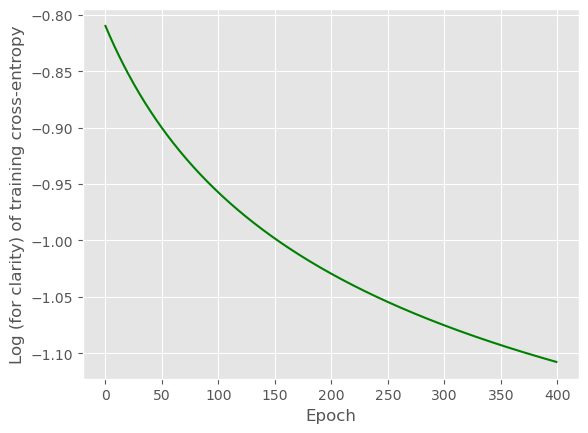

In [14]:
W_1, train_ces = train_smreg(train_Z, train_y, lr=0.3, max_epoch=400, initial_W=W_1b)

plt.plot(np.log(train_ces), color='green')
plt.xlabel('Epoch')
plt.ylabel('Log (for clarity) of training cross-entropy');

Có vẻ là nếu ta tiếp tục chạy thì độ lỗi cross-entropy sẽ còn giảm nữa, nhưng thôi, trong bài này ta sẽ tạm dừng ở đây vì laptop của mình bắt đầu kêu rồi ...

## Dùng mô hình Softmax Regression tìm được để dự đoán với dữ liệu huấn luyện và đánh giá kết quả

Đầu tiên, ta sẽ dùng mô hình Softmax Regression tìm được để dự đoán với dữ liệu huấn luyện.

In [15]:
predicted_train_y = compute_smreg_output(W_1, train_Z, return_prob=False)

Tiếp theo, ta sẽ so sánh các đầu ra dự đoán với các đầu ra đúng và đánh giá kết quả.

Nhiệm vụ của bạn (1đ): viết hàm `compute_mbe` để tính độ lỗi MBE - Mean Binary Error; độ lỗi này là một số thực từ 0 đến 100 cho biết tỉ lệ phần trăm các mẫu bị dự đoán sai (độ lỗi cross-entropy giúp dễ cực tiểu hóa hơn trong quá trình huấn luyện, nhưng khi đánh giá thì độ lỗi MBE sẽ giúp con người dễ cảm nhận hơn).

Hàm này nhận vào các tham số:
- `predicted_y`: mảng chứa các đầu ra dự đoán, có shape là `(N,)`
- `y`: mảng chứa các đầu ra đúng, cũng có shape là `(N,)`

Hàm này trả về: số thực từ 0 đến 100 cho biết độ lỗi MBE giữa `predicted_y` và `y`.

In [16]:
def compute_mbe(predicted_y, y):
    # YOUR CODE HERE
    num_error = np.count_nonzero(predicted_y != y)
    return num_error / len(y) * 100

# Gọi hàm compute_mbe để tính độ lỗi giữa predicted_train_y và train_y
train_mbe = compute_mbe(predicted_train_y, train_y)

In [17]:
# TEST
assert str(np.round(train_mbe, 4)) == '9.192'

## Tiền xử lý dữ liệu validation, dùng mô hình Softmax Regression tìm được để dự đoán với dữ liệu validation và đánh giá kết quả

In [18]:
val_Z = add_ones(val_X)
predicted_val_y = compute_smreg_output(W_1, val_Z, return_prob=False)
val_mbe = compute_mbe(predicted_val_y, val_y)
assert str(np.round(val_mbe, 4)) == '8.36'

## Đưa ra ý tưởng cải tiến

Ta thấy hiện giờ mô hình Softmax Regression tìm được của ta có độ lỗi khá cao trên cả dữ liệu huấn luyện lẫn dữ liệu validation. Nếu ta có thể làm giảm độ lỗi trên dữ liệu huấn luyện thì có khả năng độ lỗi trên dữ liệu validation cũng sẽ giảm theo. Một cách để làm giảm độ lỗi trên dữ liệu huấn luyện là tăng thêm số lượng vòng lặp của thuật toán Gradient Descent. Tuy nhiên, sau cùng thì mô hình Softmax Regression vẫn là một mô hình đơn giản. Do đó, ở đây, mình muốn đưa ra một cách khác mà có thể giúp làm giảm độ lỗi trên dữ liệu huấn luyện của mô hình Softmax Regression - một mô hình đơn giản. Cách này tương tự như cách mà ta đã làm ở HW1: suy nghĩ để thiết kế ra véc-tơ đầu vào $\textbf{z}$ thay cho véc-tơ đầu vào $\textbf{x}$ sao cho véc-tơ đầu vào $\textbf{z}$ sẽ giúp mô hình Softmax Regression dự đoán đầu ra $y$ tốt hơn hơn so với véc-tơ đầu vào $\textbf{x}$. Cụ thể ở đây, ta sẽ thử một cách thiết kế đơn giản cho véc-tơ đầu vào $\textbf{z}$: $\textbf{z}$ là $\textbf{x}$ (chứa các giá trị pixel) được bổ sung thêm 2 đặc trưng là "intensity" và "symmetry".

- "intensity" của một ảnh cho biết giá trị pixel trung bình của ảnh; đặc trưng này có thể giúp ích cho việc phân tách giữa các chữ số vì có các chữ số có ít đường nét ("intensity" thấp) và có các chữ số có nhiều đường nét ("intensity" cao) 
- "symmetry" của ảnh cho biết mức độ đối xứng của ảnh; đặc trưng này cũng có thể giúp ích cho việc phân tách giữa các chữ số vì có các chữ số có mức độ đối xứng thấp và có các chữ số có mức độ đối xứng cao. Cụ thể, "symmetry" của ảnh được tính như sau:
    - Lấy ảnh trừ đi ảnh lật theo chiều ngang, lấy trị tuyệt đối, rồi tính trung bình. Gọi kết quả tính được là s1
    - Lấy ảnh trừ đi ảnh lật theo chiều dọc, lấy trị tuyệt đối, rồi tính trung bình. Gọi kết quả tính được là s2
    - symmetry = - (s1 + s2) / 2

## Tiền xử lý dữ liệu huấn luyện

Ta sẽ tiền xử lý `train_X` bằng cách thêm vào cuối `train_X` 2 cột ứng với 2 đặc trưng đã mô tả ở trên là "intensity" và "symmetry". Ta cũng sẽ chuẩn hóa để đưa các giá trị của 2 cột này về đoạn [0, 1] bằng cách: lấy mỗi cột trừ cho min-của -cột rồi chia cho (max-của-cột trừ cho min-của-cột); ở đây, max-của-cột và min-của-cột là max và min của cột ban đầu khi chưa đụng chạm gì cả. Ta chuẩn hóa như này để miền giá trị của 2 cột này tương tự với miền giá trị của các cột trước đó (chứa các giá trị pixel) của `train_X`; việc các cột có miền giá trị tương tự nhau thường sẽ giúp cho thuật toán Gradient Descent hội tụ nhanh hơn. Sau khi đã thêm 2 cột "intensity" và "symmetry" (đã chuẩn hóa) vào cuối `train_X` thì ta sẽ thêm cột 1 vào đầu `train_X`.

Nhiệm vụ của bạn (2đ): viết hàm `add_features` để thêm 2 cột "intensity" và "symmetry" (đã chuẩn hóa). 

Hàm này có các tham số đầu vào:
- `X`: mảng chứa các véc-tơ đầu vào (chưa thêm 1 ở đầu), mảng này có shape là `(N, d)` với `N` là số lượng các véc-tơ đầu vào và `d` là số lượng phần tử của mỗi véc-tơ đầu vào 
- `mins` và `maxs`: 2 mảng chứa min và max của 2 cột "intensity" và "symmetry" (khi chưa chuẩn hóa) của *dữ liệu huấn luyện*, mỗi mảng có shape là `(2,)`. Khi gọi hàm này với dữ liệu huấn luyện thì `mins` và `maxs` sẽ bằng `None`, và bên trong hàm sẽ tính `mins` và `maxs` từ dữ liệu huấn luyện, và dùng `mins` và `maxs` này để chuẩn hóa. Khi gọi hàm này với dữ liệu mới ngoài dữ liệu huấn luyện thì cách làm chuẩn là sẽ truyền vào `mins` và `maxs` được tính từ *dữ liệu huấn luyện*, và dùng `mins` và `maxs` này để chuẩn hóa

Hàm này trả về: mảng `X` được thêm vào cuối 2 cột là "intensity" và "symmetry" (2 cột này đã được chuẩn hóa về [0, 1]), mảng kết quả này có shape là `(N, d+2)`; nếu `mins` và `maxs` truyền vào bằng None thì: ngoài mảng `X` được thêm vào cuối 2 cột mới, còn trả về thêm `mins` và `maxs` được tính từ dữ liệu (`mins` và `maxs` là mảng có shape là `(2,)`).

Để đơn giản cho bạn thì mình cho phép bạn dùng vòng lặp trong hàm `add_features` để duyệt qua các ảnh trong mảng `X`.

In [19]:
def add_features(X, mins=None, maxs=None):
    # YOUR CODE HERE
    # Tính cột intensity
    intensity = np.mean(X, axis=1)
    
    # Tính cột sysmetry
    N = X.shape[0]
    s1 = np.array([])
    s2 = np.array([])
    for i in range(0, N):
        s1 = np.append(s1, np.mean(np.abs(X[i] - np.flip(X[i].reshape(28, 28), axis=1).flatten())))
        s2 = np.append(s2, np.mean(np.abs(X[i] - np.flip(X[i].reshape(28, 28), axis=0).flatten())))
    symmetry = - (s1 + s2) / 2

    # Tính mins, maxs
    if mins is None:
        mins_ = []
        maxs_ = []
        mins_.append(np.min(intensity))
        mins_.append(np.min(symmetry))
        maxs_.append(np.max(intensity))
        maxs_.append(np.max(symmetry))
        
        minss = np.array(mins_)
        maxss = np.array(maxs_)
    else:
        minss = mins
        maxss = maxs
    
    # Chuẩn hóa
    intensity = (intensity - minss[0]) / (maxss[0] - minss[0])
    symmetry = (symmetry - minss[1]) / (maxss[1] - minss[1])
    
    # Thêm cột
    Z = np.hstack((X, intensity[:, np.newaxis]))
    Z = np.hstack((Z, symmetry[:, np.newaxis]))
    
    if mins is None:
        return Z, minss, maxss
    return Z

In [20]:
# TEST
X = train_X[:5]
Z, mins, maxs = add_features(X)
assert Z.shape == (5, 786)
assert str(Z[0, -2].round(4)) == '0.7443'
assert str(Z[0, -1].round(4)) == '0.44'
assert mins.shape == (2,)
assert str(mins[0].round(4)) == '0.0854'
assert str(mins[1].round(4)) == '-0.2051'
assert maxs.shape == (2,)
assert str(maxs[0].round(4)) == '0.1549'
assert str(maxs[1].round(4)) == '-0.1427'

X = val_X[:5]
Z = add_features(X, mins, maxs)
assert Z.shape == (5, 786)
assert str(Z[0, -2].round(4)) == '0.3761'
assert str(Z[0, -1].round(4)) == '1.9915'

Ở trên, ta chỉ thử với dữ liệu nhỏ để nhanh chóng kiểm tra tính đúng đắn của hàm `add_features`. Bây giờ ta mới làm thật: gọi hàm `add_features` rồi `add_ones` để tiền xử lý `train_X`.

In [21]:
train_Z, mins_for_add_features, maxs_for_add_features = add_features(train_X)
train_Z = add_ones(train_Z)
train_Z.shape

(50000, 787)

## Tìm mô hình Softmax Regression từ dữ liệu huấn luyện

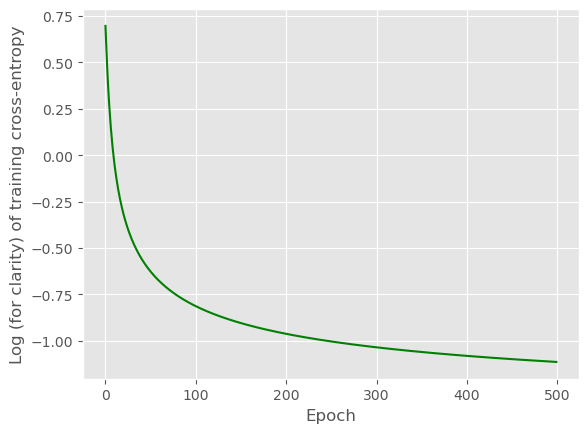

In [22]:
W_2, train_ces = train_smreg(train_Z, train_y, lr=0.3, max_epoch=500)

plt.plot(np.log(train_ces), color='green')
plt.xlabel('Epoch')
plt.ylabel('Log (for clarity) of training cross-entropy');

## Dùng mô hình Softmax Regression tìm được để dự đoán với dữ liệu huấn luyện và đánh giá kết quả

In [23]:
predicted_train_y = compute_smreg_output(W_2, train_Z, return_prob=False)
train_mbe = compute_mbe(predicted_train_y, train_y)
assert str(np.round(train_mbe, 4)) == '9.116'

Như vậy là độ lỗi MBE trên dữ liệu huấn luyện giảm từ 9.192 xướng 9.116. Hmm ... giảm không đáng kể (chắc là do cách thiết kế véc-tơ đầu vào $\textbf{z}$ của ta còn đơn giản), nhưng dù sao cũng có giảm ...

## Tiền xử lý dữ liệu validation, dùng mô hình Softmax Regression tìm được để dự đoán với dữ liệu validation và đánh giá kết quả

In [24]:
val_Z = add_ones(add_features(val_X, mins_for_add_features, maxs_for_add_features))
predicted_val_y = compute_smreg_output(W_2, val_Z, return_prob=False)
val_mbe = compute_mbe(predicted_val_y, val_y)
assert str(np.round(val_mbe, 4)) == '8.27'

Độ lỗi MBE trên dữ liệu validation cũng giảm theo: giảm từ 8.36 xuống 8.27.

## Chọn ra cách tiền xử lý + mô hình Softmax Regression sau cùng là cách tiền xử lý + mô hình Softmax Regression mà có độ lỗi dự đoán thấp nhất trên dữ liệu validation

Như vậy ta sẽ chọn cách tiền xử lý là `add_ones(add_features(..., mins_for_add_features, maxs_for_add_features))` và mô hình Softmax Regression có bộ trọng số là `W_2`.

## Dùng cách tiền xử lý + mô hình Softmax Regression sau cùng để đi thi thật!

In [25]:
test_Z = add_ones(add_features(test_X, mins_for_add_features, maxs_for_add_features))
predicted_test_y = compute_smreg_output(W_2, test_Z, return_prob=False)
test_mbe = compute_mbe(predicted_test_y, test_y)
assert str(np.round(test_mbe, 4)) == '8.6'

Giờ thì đi ngủ được rồi ...